# Week 1 solutions

Gerya problems 1.2 and 2.2 - implementation in Julia (1.7.1)

In [1]:
using PyPlot

# Problem 1.2

Gerya asks us to compute and visualize a velocity field of the form
$$
v_x(x,y) = -vx_0 \sin(2\pi x / W) \cos(\pi y/H)\\
v_y(x,y) = -vy_0 \cos(2\pi x / W) \sin(\pi y/H)
$$

I computed the divergence of the velocity as
$$
\nabla\cdot \underline{v} = \left(-vx_0 (2\pi/W)- vy_0 (\pi/H)\right) \cos(2\pi x / W) \cos(\pi y/H) 
$$

If we choose $vx_0 = -vy_0\frac{W}{2H}$, the divergence is zero

In [26]:
# set the domain width and height
width = 1.5e6
height = 1e6
# set the magnitude of the velocity.
vx0 = -1e-9/2*1.5 # m/s
vy0 = 1e-9 # m/s

# set the number of grid points in the x and y directions.
nx=46
ny=31

x = range(0, width, length = nx)
y = range(0, height, length = ny)

# define anonymous functions representing vx, vy, and div(v)
vx(x, y) = -vx0*sin(2pi*x/width)*cos(pi*y/height)
vy(x, y) = -vy0*cos(2pi*x/width)*sin(pi*y/height)
dvx_dx(x,y) = -vx0*(2pi/width)*cos(2pi*x/width)*cos(pi*y/height)
dvy_dy(x,y) = -vy0*(pi/height)*cos(2pi*x/width)*cos(pi*y/height)
divv(x,y) = dvx_dx(x,y) + dvy_dy(x,y)
            
vxp = [vx(x,y) for y in y, x in x];
vyp = [vy(x,y) for y in y, x in x];
dvx_dxp = [dvx_dx(x,y) for y in y, x in x];
dvy_dyp = [dvy_dy(x,y) for y in y, x in x];
divvp = [divv(x,y) for y in y, x in x];

# Plotting
Plot the velocity field (x component and y component) and the divergence field (with quiver (arrows) indicating velocities).

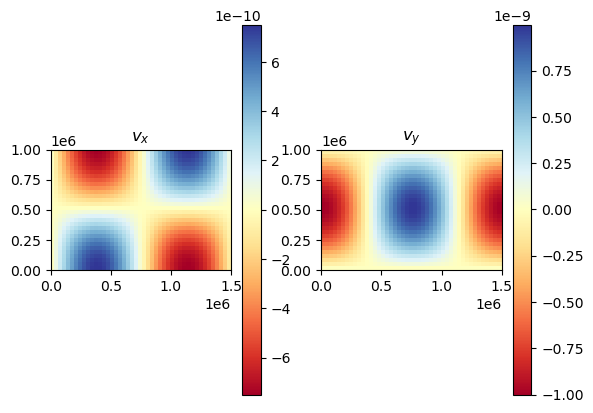

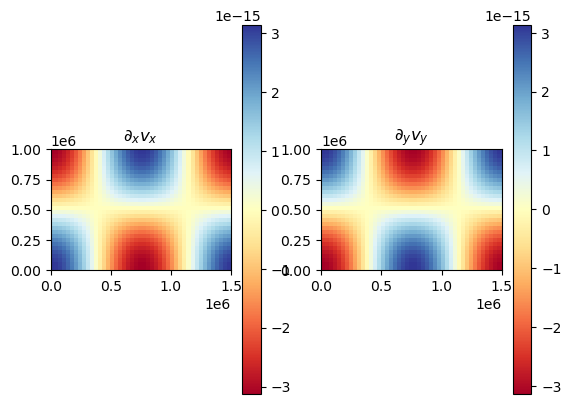

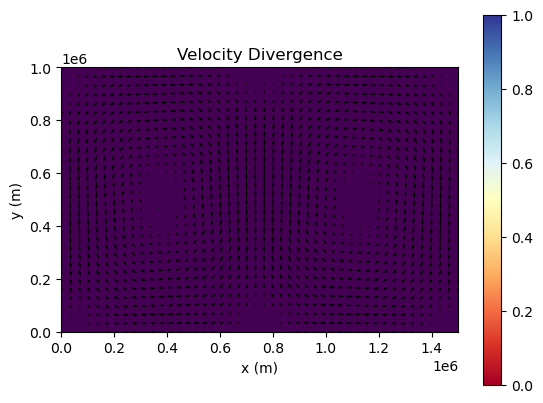

In [47]:
# Note that this plotting code uses the interface to pyplot
colormap = get_cmap("RdYlBu")
figure()
subplot(1,2,1)
pcolor(x,y,vxp,cmap=colormap)
gca().set_aspect("equal")
colorbar()
title("\$v_x\$")
subplot(1,2,2)
pcolor(x,y,vyp,cmap=colormap)
gca().set_aspect("equal")
colorbar()
title("\$v_y\$")
show()

figure()
subplot(1,2,1)
pcolor(x,y,dvx_dxp,cmap=colormap)
gca().set_aspect("equal")
colorbar()
title("""\$\\partial_x v_x\$""")
subplot(1,2,2)
pcolor(x,y,dvy_dyp,cmap=colormap)
gca().set_aspect("equal")
colorbar()
title("""\$\\partial_y v_y\$""")
show()


figure()
pcolor(x,y,divvp)
gca().set_aspect("equal")
quiver(x,y,vxp,vyp,cmap=colormap)
title("Velocity Divergence")
xlabel("x (m)")
ylabel("y (m)")
colorbar()
show()

# Problem 2.2